![Image](../../resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Population Coding</h1> 
<h2 align="center"> SWDB 2024 - Day 2 - Afternoon Session </h2> 
<h3 align="center"> Tuesday, August 20, 2024</h3> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> 

### Questions  

In the first workshop of today, we examined how sensory variables can be encoded in individual neurons' activity. 

We now turn our attention to the **coordinated activity of groups of neurons: population codes!**

Key questions:
* How do populations of neurons encode information about task-relevant sensory information? 
* How are these population codes modulated by task context or behavioral state? 
* What other types of thing are encoded in population activity?

![neural_coding.png](../resources/neural_coding.png)

In [20]:
### Add general description of what population coding is and what its for

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>


What data and tools do we need to address the question of population coding? 

**insert descriptive text**

</div>

In [21]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%autoreload 2
%matplotlib inline

UsageError: Line magic function `%autoreload` not found.


#### Load the cache and get metadata tables

In [22]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [23]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [24]:
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# get the metadata tables
units_table = cache.get_unit_table()

channels_table = cache.get_channel_table()

probes_table = cache.get_probe_table()

behavior_sessions_table = cache.get_behavior_session_table()

ecephys_sessions_table = cache.get_ecephys_session_table()

### First, let's load data from a recording session.

In [25]:
session = cache.get_ecephys_session(ecephys_session_id=1065437523)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


#### The stimulus presentations table is a record of every stimulus we presented to the mouse over the course of this experiment. Let's take a look at this table.

In [26]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.head(-5)

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,color,position_y,contrast,active,stimulus_index,spatial_frequency,orientation,stimulus_name,position_x,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,5,im047_r,0.250210,8776.735046,8776.985256,522677,522692,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
13382,5,im047_r,0.250207,8777.485673,8777.735881,522722,522737,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
13383,5,im047_r,0.250208,8778.236296,8778.486503,522767,522782,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False


#### It contains a great deal of information about the stimulus presentations! Let's look at all the columns:

In [27]:
stimulus_presentations.columns

Index(['stimulus_block', 'image_name', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'flashes_since_change', 'trials_id', 'rewarded', 'temporal_frequency',
       'color', 'position_y', 'contrast', 'active', 'stimulus_index',
       'spatial_frequency', 'orientation', 'stimulus_name', 'position_x',
       'is_sham_change'],
      dtype='object')

#### The different stimuli are indexed by the `stimulus_block` column. Let's group this dataframe by stimulus block and see what stimulus was shown for each block.

In [28]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.groupby('stimulus_block')[['stimulus_block', 
                                                'stimulus_name', 
                                                'active', 
                                                'duration', 
                                                'start_time']].head()

,stimulus_block,stimulus_name,active,duration,start_time
stimulus_presentations_id,,,,,
0,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250188,28.131464
1,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250188,28.882028
2,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250232,29.632680
3,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250186,30.383329
4,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250229,31.133886
4797,1,spontaneous,False,10.008420,3648.207579
4798,2,gabor_20_deg_250ms,False,0.250208,3658.215999
4799,2,gabor_20_deg_250ms,False,0.250208,3658.466207
4800,2,gabor_20_deg_250ms,False,0.250208,3658.716415


<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
<p>
 
What are the types of stimulus block that were presented?

In [29]:
stimulus_presentations['stimulus_name'].unique()

array(['Natural_Images_Lum_Matched_set_ophys_G_2019', 'spontaneous',
       'gabor_20_deg_250ms', 'flash_250ms'], dtype=object)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
<p>

What stimuli were shown in the 'Natural_Images_Lum_Matched_set_ophys_G_2019' block?

In [30]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == 'Natural_Images_Lum_Matched_set_ophys_G_2019']
stimulus_presentations.head(-5)

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,color,position_y,contrast,active,stimulus_index,spatial_frequency,orientation,stimulus_name,position_x,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,NaN,NaN,NaN,True,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,5,im047_r,0.250210,8776.735046,8776.985256,522677,522692,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
13382,5,im047_r,0.250207,8777.485673,8777.735881,522722,522737,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False
13383,5,im047_r,0.250208,8778.236296,8778.486503,522767,522782,False,False,False,...,NaN,NaN,NaN,False,-99,NaN,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,False


In [31]:
np.sort(stimulus_presentations['image_name'].unique())

array(['im012_r', 'im036_r', 'im044_r', 'im047_r', 'im078_r', 'im083_r',
       'im111_r', 'im115_r', 'omitted'], dtype=object)

### We'll also want some information about the mouse behavior! This is contained in the "trials" table. Let's take a quick look at it:

In [32]:
trials = session.trials
trials['change_time'] = trials['change_time_no_display_delay'] # a slightly easier name for this column

trials.head()

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,...,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,change_time
trials_id,,,,,,,,,,,,,,,,,,,,,
0,28.08763,29.05453,im036_r,im036_r,False,NaN,False,False,"[28.55387, 28.73684, 29.30404]",NaN,...,0.000,False,False,False,False,True,False,-99,0.96690,NaN
1,29.58829,36.86108,im036_r,im078_r,True,32.59106,False,False,"[33.04048, 33.20773, 33.30745, 33.3908, 33.507...",33.04048,...,0.005,False,False,False,False,False,True,330,7.27279,32.59106
2,37.09446,40.78107,im078_r,im078_r,False,NaN,False,False,[40.48052],NaN,...,0.000,False,False,False,False,True,False,-99,3.68661,NaN
3,40.84754,50.37230,im078_r,im111_r,True,46.10256,False,False,"[46.73531, 46.83539, 46.95218, 47.06898, 47.20...",46.73531,...,0.005,False,False,False,False,False,True,1140,9.52476,46.10256
4,50.60569,51.75679,im111_r,im111_r,False,NaN,False,False,[51.43985],NaN,...,0.000,False,False,False,False,True,False,-99,1.15110,NaN


In [33]:
trials.columns

Index(['start_time', 'stop_time', 'initial_image_name', 'change_image_name',
       'is_change', 'change_time_no_display_delay', 'go', 'catch',
       'lick_times', 'response_time', 'reward_time', 'reward_volume', 'hit',
       'false_alarm', 'miss', 'correct_reject', 'aborted', 'auto_rewarded',
       'change_frame', 'trial_length', 'change_time'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
How many trials are there and how many stimulus presentations?

In [34]:
print('{} trials'.format(len(trials)))
print('{} stimulus presentations'.format(len(stimulus_presentations)))

567 trials
9594 stimulus presentations


<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
What does the distribution of trial lengths look like? What does distribution of aborted trial lengths look like?

Text(0.5, 1.0, 'Aborted trials')

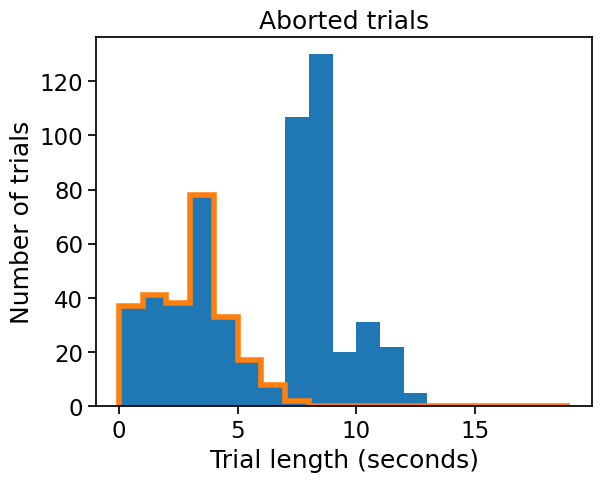

In [35]:
duration_bins = np.arange(0, 20, 1)

plt.figure()
plt.hist(trials['trial_length'].values, bins=duration_bins, label='All trials')
plt.xlabel('Trial length (seconds)')
plt.ylabel('Number of trials')
plt.title('All trials')

plt.hist(trials['trial_length'].values[trials['aborted'].values], bins=duration_bins, label='Aborted trials', histtype='step', linewidth=4)
plt.title('Aborted trials')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">Now, how well does the mouse do the task? What are its hit, miss, and false alarm rates? 


    
The pre-computed false alarms and correct rejections are computed from "catch" trials, in which the image does not change at the scheduled change time. If the mouse licks before the change, the trial is aborted. This could also be called a false alarm. 

Note that the first few trials are auto-rewarded, and should not be counted.

In [36]:
num_catch_trials = np.sum(trials['catch'].values)
num_go_trials = len(trials) - np.sum(trials['auto_rewarded'].values) - num_catch_trials

In [37]:
num_aborted_trials = np.sum(trials['aborted'].values)

print('Total trials: {}'.format(num_go_trials + num_catch_trials))
print('Go trials: {}'.format(num_go_trials))
print('Aborted go trials: {}'.format(num_aborted_trials))
print('Catch trials: {}'.format(num_catch_trials))

Total trials: 564
Go trials: 526
Aborted go trials: 254
Catch trials: 38


In [38]:
print('Hit rate: {}'.format(np.sum(trials['hit']) / num_go_trials ))
print('Abort (false alarm) rate: {}'.format(num_aborted_trials / len(trials) ))
print('Miss rate: {}'.format(np.sum(trials['miss']) / num_go_trials ))

Hit rate: 0.41254752851711024
Abort (false alarm) rate: 0.4479717813051146
Miss rate: 0.10456273764258556


### Now let's get unit and channel data, sort the units by depth and filter for "good" units.

In [39]:
### get unit and channel data, sort the units by depth and filter for "good" units
units = session.get_units() # contains information about spike waveforms, isolation quality
channels = session.get_channels() # contains information about anatomical location

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

#first let's sort our units by depth and filter
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    Which brain structures were recorded from in this session? How many units are present in each structure? (Hint: try the "value_counts" function.)

In [40]:
unit_channels.value_counts('structure_acronym')

structure_acronym
SGN      260
CA1      228
DG       167
VISpm    165
APN      151
TH       146
VISam    144
VISp     131
VISl     127
VISal    125
MRN      106
VISrl     99
ProS      98
PP        94
PIL       74
PoT       70
CA3       67
SUB       52
LP        24
MGm       21
NOT       18
RN        17
MB        15
POST       2
LT         2
MGv        1
dtype: int64

### For now, let's look at the population activity in primary visual cortex

In [41]:
area_of_interest = 'VISp'
area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)

### Let's start by looking at the neural activity! Does it reflect the image presentation?

### The session.spike_times object contains all spike times, in seconds, indexed by the unit ID. Let's take a look at this object.

In [42]:
spike_times = session.spike_times
spike_times

{1068230174: array([9.44254618e+00, 2.33621481e+01, 2.34528150e+01, ...,
        9.50809482e+03, 9.51961755e+03, 9.52079809e+03]),
 1068230173: array([6.85353963e+00, 1.12225507e+01, 1.51770274e+01, ...,
        9.53846293e+03, 9.53847370e+03, 9.53979757e+03]),
 1068229957: array([4138.03009707, 4542.21778688, 4542.4386541 , ..., 9539.18743594,
        9539.33773632, 9539.83660425]),
 1068229949: array([4.66810076e+00, 4.71560088e+00, 4.72050090e+00, ...,
        9.53462899e+03, 9.53743216e+03, 9.53826630e+03]),
 1068229887: array([4.69210083e+00, 5.04563505e+00, 5.26246894e+00, ...,
        9.53967004e+03, 9.53979680e+03, 9.53983434e+03]),
 1068229886: array([4.70133418e+00, 5.09830185e+00, 5.35013582e+00, ...,
        9.53971987e+03, 9.53974080e+03, 9.53978037e+03]),
 1068229911: array([4.97070153e+00, 5.39926928e+00, 5.45693609e+00, ...,
        9.53975597e+03, 9.53984134e+03, 9.53989457e+03]),
 1068230009: array([5.59440311e+00, 7.24834063e+00, 1.64365972e+01, ...,
        9.539629

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

Get the array of spike times for unit 1068230173. How many times does this unit spike in the first minute of the experiment?

In [43]:
unit_spike_times = spike_times[1068230173]
unit_spike_times

array([6.85353963e+00, 1.12225507e+01, 1.51770274e+01, ...,
       9.53846293e+03, 9.53847370e+03, 9.53979757e+03])

In [44]:
sum(unit_spike_times < 60)

33

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

Plot a population spike raster spanning 1 second before to 1 second after a stimulus presentation. Fill in the code in the for 

(0.0, 72.0)

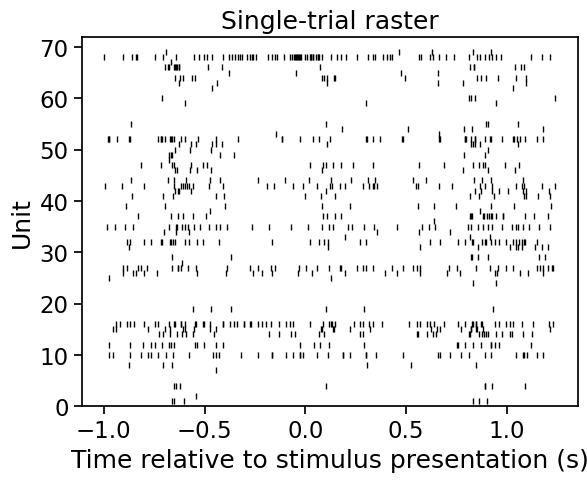

In [45]:
### plot a single-trial raster, population PSTH, and representation matrix
pre_time = 1
post_time = 1

fig, ax = plt.subplots(1, 1)

presentation_idx = 1
start_time = stimulus_presentations['start_time'][presentation_idx] # in seconds - start one second before this
end_time = stimulus_presentations['end_time'][presentation_idx] # in seconds - go to one second after this

unit_num = 0
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    
    unit_spike_times = unit_spike_times[(unit_spike_times >= start_time - pre_time) * (unit_spike_times < end_time + post_time)]
    unit_num_spikes = len(unit_spike_times)
    
    ax.plot(unit_spike_times - start_time, unit_num*np.ones(unit_num_spikes,), 'k|', markersize=5)
    unit_num += 1

ax.set_title('Single-trial raster')
ax.set_xlabel('Time relative to stimulus presentation (s)')
ax.set_ylabel('Unit')
ax.set_ylim((0, num_units+1))

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
Now let's compare to a change trial.

(0.0, 71.0)

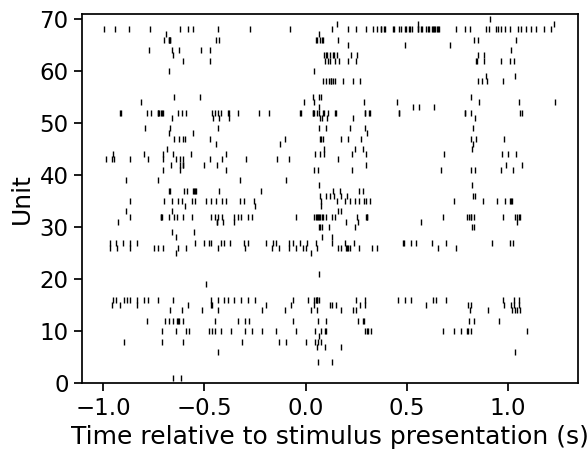

In [46]:

### plot a single-trial raster, population PSTH, and representation matrix
fig, ax = plt.subplots(1, 1)

change_idx = np.where(stimulus_presentations['is_change'].values)[0]
presentation_idx = change_idx[0]

start_time = stimulus_presentations['start_time'][presentation_idx]
end_time = stimulus_presentations['end_time'][presentation_idx]

unit_num = 0
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    
    unit_spike_times = unit_spike_times[(unit_spike_times >= start_time - pre_time) * (unit_spike_times < end_time + post_time)]
    unit_num_spikes = len(unit_spike_times)
    
    ax.plot(unit_spike_times - start_time, unit_num*np.ones(unit_num_spikes,), 'k|', markersize=5)
    unit_num += 1

ax.set_xlabel('Time relative to stimulus presentation (s)')
ax.set_ylabel('Unit')
ax.set_ylim((0, num_units))

### Now let's take a look at the trial-averaged responses to see how a neuron encodes the stimulus in its time-dependent firing rate (its peri-stimulus time histogram, or PSTH).

In [47]:
#Convenience function to compute the PSTH
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

Let's start by plotting the response of unit 0 to one of the images.

In [48]:
stimuli = stimulus_presentations['image_name'].unique()
stimulus = stimuli[0]

In [49]:
print(stimuli)

['im036_r' 'im078_r' 'omitted' 'im111_r' 'im047_r' 'im083_r' 'im012_r'
 'im115_r' 'im044_r']


In [50]:
presentations = stimulus_presentations[stimulus_presentations['image_name'] == stimulus]
num_presentations = len(presentations)

start_times = presentations['start_time'].values

In [51]:
unit_ids = area_units.index
iu = unit_ids[0]
unit_spike_times = spike_times[iu]

Text(0.5, 1.0, 'PSTH for im036_r')

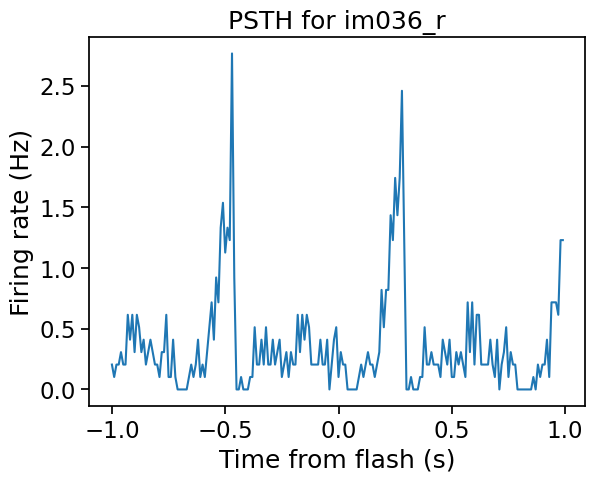

In [52]:
time_before_im = 1
duration = 2

unit_response, bins = makePSTH(unit_spike_times, 
                                  start_times - time_before_im, 
                                  duration, binSize=0.01)

fig, ax = plt.subplots(1, 1)
ax.plot(bins[:-1] - time_before_im, unit_response)
ax.set_xlabel('Time from flash (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
Plot the PSTHs for every unit to that image.

Text(0.5, 1.0, 'PSTH for im036_r')

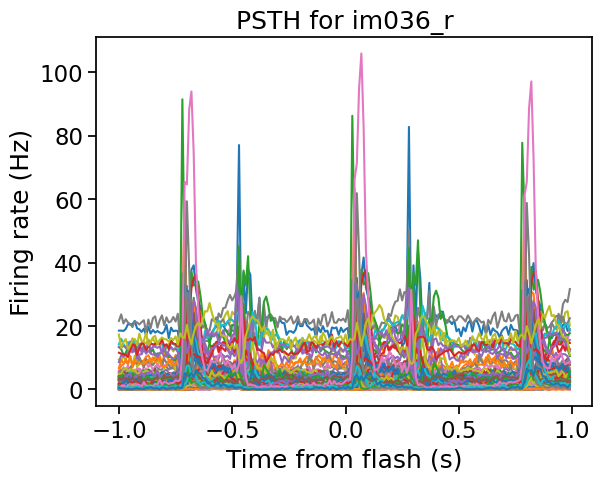

In [53]:
### Plot a set of PSTHs

psths = []
fig, ax = plt.subplots(1, 1)

for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]  
    unit_response, bins = makePSTH(unit_spike_times, 
                                      start_times - time_before_im, 
                                      duration, binSize=0.01)
    
    psths.append(unit_response)
    ax.plot(bins[:-1]-time_before_im, unit_response)
    
ax.set_xlabel('Time from flash (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

### We can see the trial structure of the task reflected in the PSTH. Some units have very strong transient responses to the image presentation. Do these responses depend on the task structure (whether the image is a change or not)?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
Plot the PSTHs for every unit to that image on change trials only. Are the same neurons the most responsive on change trials as on average?

Text(0.5, 1.0, 'PSTH for im036_r')

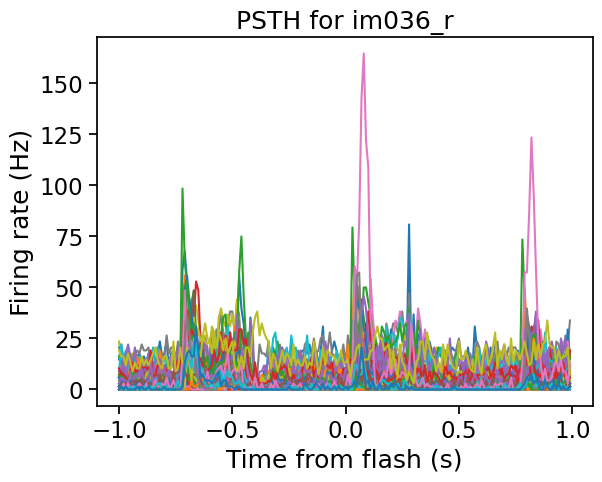

In [54]:
change_start_times = start_times[presentations['is_change'].values.astype('bool')]

psths = []
fig, ax = plt.subplots(1, 1)

for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]  
    unit_response, bins = makePSTH(unit_spike_times, 
                                      change_start_times - time_before_im, 
                                      duration, binSize=0.01)
    
    psths.append(unit_response)
    ax.plot(bins[:-1]-time_before_im, unit_response)
    
ax.set_xlabel('Time from flash (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
Plot the PSTHs for every unit to another image on change trials. Do the same neurons have the strongest responses?

Text(0.5, 1.0, 'PSTH for im078_r')

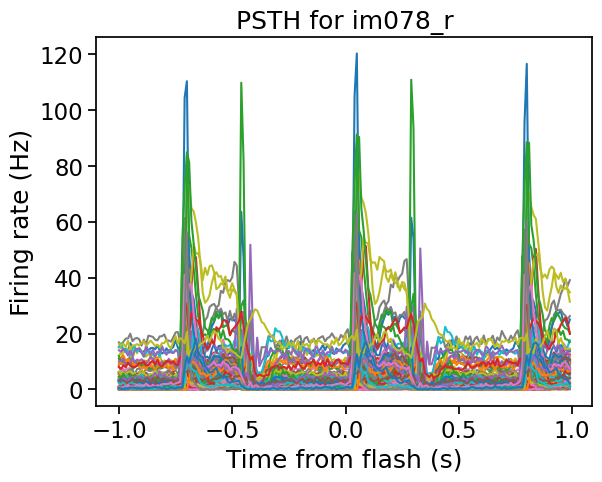

In [55]:
stimulus = stimuli[1]

presentations = stimulus_presentations[stimulus_presentations['image_name'] == stimulus]
start_times = presentations['start_time'].values
change_start_times = start_times[presentations['is_change'].values.astype('bool')]

num_presentations = len(presentations)

start_times = presentations['start_time'].values

fig, ax = plt.subplots(1, 1)

for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]  
    unit_response, bins = makePSTH(unit_spike_times, 
                                      start_times - time_before_im, 
                                      duration, binSize=0.01)
    
    psths.append(unit_response)
    ax.plot(bins[:-1]-time_before_im, unit_response)
    
ax.set_xlabel('Time from flash (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

## Training a classifier on population spiking data
Now we'll look at how the population activity encodes the image change. To determine how well we can decode the image change from population activity, we will train a **classifier** on a matrix of firing rates. Whereas regression models try to predict continuous values from the input features, classification models try to predict *labels* (also known as classes) from the input features.

### Support Vector Machines

Let's start with a linear Support Vector Machine (SVM) classifier, which will try to draw linear boundaries between orientation conditions (the labels) in our high-dimensional firing rate space.

This cartoon shows how we would expect an SVM to behave on a dataset with two dimensions and three conditions:


![SVM illustration](../resources/svm-classifier.png)



![SVM illustration](../../resources/svm-classifier.png)

SVM computes decision boundaries in feature space that can be used to classify different conditions. If a new data point appears, the SVM classifier will label it based on where it falls with respect to these boundaries.

To train an SVM, we need to import the following methods from `scikit-learn`:

In [56]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix

### First, we need to create a response matrix and vector of stimulus labels. It'll be convenient to have some of the trial-related information in the stimulus table.

In [57]:
def add_trials_id_to_stimulus_presentations(stimulus_presentations, trials):
    """
    Add trials_id to stimulus presentations by finding the closest change time to each stimulus start time
    If there is no corresponding change time, the trials_id is NaN
    :param: stimulus_presentations: stimulus_presentations attribute of BehaviorOphysExperiment object, must have 'start_time'
    :param trials: trials attribute of BehaviorOphysExperiment object, must have 'change_time'
    """
    # for each stimulus_presentation, find the trials_id that is closest to the start time
    # add to a new column called 'trials_id'
    for idx, stimulus_presentation in stimulus_presentations.iterrows():
        start_time = stimulus_presentation['start_time']
        query_string = 'change_time > @start_time - 1 and change_time < @start_time + 1'
        trials_id = (
            np.abs(start_time - trials.query(query_string)['change_time']))
        if len(trials_id) == 1:
            trials_id = trials_id.idxmin()
        else:
            trials_id = np.nan
        stimulus_presentations.loc[idx, 'trials_id'] = trials_id
    return stimulus_presentations


def add_trials_data_to_stimulus_presentations_table(stimulus_presentations, trials):
    """
    Add trials_id to stimulus presentations table then join relevant columns of trials with stimulus_presentations
    :param: stimulus_presentations: stimulus_presentations attribute of BehaviorOphysExperiment object, must have 'start_time'
    :param trials: trials attribute of BehaviorOphysExperiment object, must have 'change_time'
    """
    # add trials_id and merge to get trial type information
    stimulus_presentations = add_trials_id_to_stimulus_presentations(
        stimulus_presentations, trials)
    # only keep certain columns
    trials = trials[['change_time', 'go', 'catch', 'aborted', 'auto_rewarded',
                     'hit', 'miss', 'false_alarm', 'correct_reject',
                     'response_time', 'response_time', 'reward_time', 'reward_volume', ]]
    # merge trials columns into stimulus_presentations
    stimulus_presentations = stimulus_presentations.reset_index().merge(
        trials, on='trials_id', how='left')
    stimulus_presentations = stimulus_presentations.set_index(
        'stimulus_presentations_id')
    return stimulus_presentations

In [61]:
all_stimulus_presentations = session.stimulus_presentations

print('Total trials: {}'.format(len(all_stimulus_presentations)))
print('Change trials: {}'.format(np.sum(all_stimulus_presentations['is_change'].values)))

Total stimulus presentations: 544
Change trials: 272


### The vast majority of stimulus presentations (~95%) are not a change. So a decoder could get 95% accuracy by predicting that there are no changes!

To avoid this, we will balance the trials and decode change vs pre-change. We also don't want to include the 5 auto-rewarded trials at the beginning of the session. 

In [60]:
trials = session.trials
trials['change_time'] = trials['change_time_no_display_delay']

# add pre-change
all_stimulus_presentations['pre_change'] = all_stimulus_presentations['is_change'].shift(
    -1)

# add trials information to the stimulus presentations table
all_stimulus_presentations = add_trials_id_to_stimulus_presentations(all_stimulus_presentations, trials)
all_stimulus_presentations = add_trials_data_to_stimulus_presentations_table(all_stimulus_presentations, trials)

# isolate the trials to use for decoding
decode_trial_ind = (all_stimulus_presentations['is_change'].values + all_stimulus_presentations['pre_change'].values)
stimulus_presentations = all_stimulus_presentations[decode_trial_ind]

not_auto_rewarded_ind = [~a for a in stimulus_presentations['auto_rewarded'].values.astype('bool')]
stimulus_presentations = stimulus_presentations[not_auto_rewarded_ind]

### Now let's make our matrix of responses and vector of labels.

In [62]:
def make_response_array(spike_times, stimulus_presentations, units, window=.05):

    '''
    Create an array of spike counts x stimulus presentations, and a corresponding list of stimulus label
    spike_times: spike times 
    stimulus_presentation: stimulus presentation table
    units: units table containing only the units to get the responses of
    '''

    # sort spike times chronologically; necessary for the binary search later
    sorted_spikes = dict()
    for iu in units.index:
        # mergesort/timsort since most spike_times are already sorted
        sorted_spikes[iu] = np.sort(spike_times[iu], kind='mergesort')

    # create our own copy of stimulus presentations and sort by presentation start time chronologically
    # sortation of stimulus_presentations isn't necessary, but it speeds up the vectorized `searchsorted(...)`
    stimulus_presentations = stimulus_presentations.sort_values(by='start_time', kind='mergesort', inplace=False)

    # Calculate the duration of stimulus presentations, and drop NaN durations
    stimulus_presentations['duration'] = stimulus_presentations['end_time'] - stimulus_presentations['start_time']
    stimulus_presentations.dropna(subset='duration', inplace=True)
    
    # Warn if window size is too big
    if np.any(window > stimulus_presentations['duration']):
        print('Warning: window size longer than stimulus presentation')

    responses_by_unit = list()
    for iu in units.index:
        unit_spike_times = sorted_spikes[iu]

        # Determine the first and last spike time for each stimulus presentation
        start_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'])
        end_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time']+window)

        # presentation_spike_times = unit_spike_times[start_i:end_i]

        # Calculate the response rate for each stimulus presentation
        responses_by_unit.append((end_is - start_is) / stimulus_presentations['duration'])

    # responses_by_unit has each row a unit, and each column a stimulus, flip so that rows are stimuli
    responses = np.transpose(responses_by_unit)

    # Extract the labels that match the responses from our sorted stimulus presentations table
    labels = np.array(stimulus_presentations['is_change']).astype('int')
        
    # Extract the mouse's behavioral response
    hit = np.array(stimulus_presentations['hit']).astype('int')
    miss = np.array(stimulus_presentations['miss']).astype('int')
   
    return responses, labels, hit, miss

In [63]:
responses, labels, hit, miss = make_response_array(spike_times, stimulus_presentations, area_units, window=.07)

### We will first select a random subset of trials for training the classifier:

In [64]:
total_presentations = responses.shape[0]
num_train = int(total_presentations * 0.5) # Use 50% of trials for training
random_trial_order = np.random.permutation(responses.shape[0])
train_indices = random_trial_order[:num_train]

training_data = responses[train_indices]
training_labels = labels[train_indices]

### Next, we'll create the model and fit it to our training data:

In [65]:
clf = svm.SVC()
clf.fit(responses[train_indices], labels[train_indices])

SVC()

### Now that our model has been trained, we can ask it to classify unlabeled data (i.e., the sets of population firing rates that were not included in our original training set):

In [66]:
test_indices = random_trial_order[num_train:]
test_data = responses[test_indices]
predicted_labels = clf.predict(responses[test_indices])

### We can compare the predicted labels to the actual labels in order to assess the classifier's performance. We'll assess accuracy as the fraction of correctly predicted test images. As a baseline, we'll also compute the accuracy of a uniform random prediction.

In [67]:
conditions = np.unique(labels)

actual_labels = labels[test_indices]
accuracy = np.mean(actual_labels == predicted_labels)

print('Accurary: {}'.format(accuracy))
print('Chance level: {}'.format(1/len(conditions)))

Accurary: 0.7794117647058824
Chance level: 0.5


### We see that we perform better than chance! We can get a better sense of classification performance by using leave-one-out cross-validation. The `scikit-learn.model_selection.LeaveOneOut` iterator will automatically cycle through trials, on each iteration using one trial as a test and the others to train the classifier. Note that the model is fit independently on each iteration.

In [68]:
accuracies = []
confusions = []

conditions = np.unique(labels)
num_splits = 5

for train_indices, test_indices in LeaveOneOut().split(responses):
    
    clf = svm.SVC()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
#     print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

The leave-one-out cross-validation roughly agrees with our previous result. Do we do better on change or pre-change images? To assess this we'll look at the confusion matrix, which tells us how frequently each condition is predicted on change and pre-change presentations.

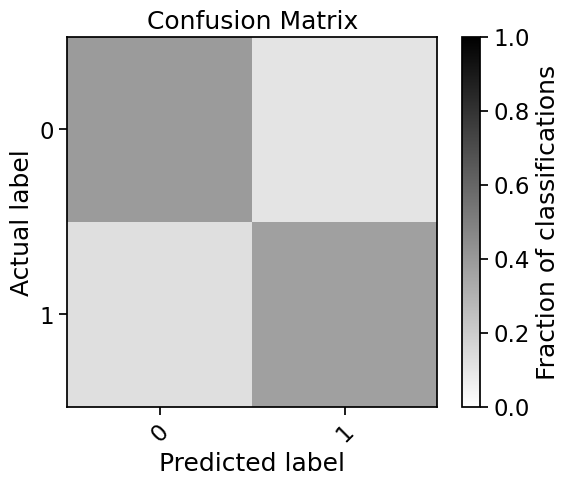

In [69]:
def plot_confusion_matrix(confusions, conditions, title=None):
    
    mean_confusion = np.mean(confusions, axis=0)

    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(mean_confusion, cmap='gray_r', clim=(0, 1))
    plt.colorbar(im, ax=ax, label='Fraction of classifications')
    
    ax.set_xticks(range(len(conditions)), conditions, rotation=45)
    ax.set_yticks(range(len(conditions)), conditions)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("Actual label")
    if title is None:
        ax.set_title('Confusion Matrix')
    elif type(title) is str:
        ax.set_title(title)
    
plot_confusion_matrix(confusions, conditions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
How does this V1-based decoder perform on hit trials vs miss trials?

In [70]:
accuracies = []
accuracies_hit = []
accuracies_miss = []

confusions = []
confusions_hit = []
confusions_miss = []

conditions = np.unique(labels)

for train_indices, test_indices in LeaveOneOut().split(responses):
    
    clf = svm.SVC()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)        
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize=None))
    
    test_hit = hit[test_indices].astype('bool')
    test_miss = miss[test_indices].astype('bool')
    
    if hit[test_indices].astype('bool'):
        accuracies_hit.append(accuracy)
        confusions_hit.append(confusion_matrix(y_true=test_targets[test_hit], y_pred=test_predictions[test_hit], labels=conditions, normalize=None))
        
    elif miss[test_indices].astype('bool'):
        accuracies_miss.append(accuracy)
        confusions_miss.append(confusion_matrix(y_true=test_targets[test_miss], y_pred=test_predictions[test_miss], labels=conditions, normalize=None))

print('Mean accuracy: {}'.format(np.mean(accuracies)))
print('Mean accuracy, hit trials: {}'.format(np.mean(accuracies_hit)) )
print('Mean accuracy, miss trials: {}'.format(np.mean(accuracies_miss)) ) 

Mean accuracy: 0.7647058823529411
Mean accuracy, hit trials: 0.7926267281105991
Mean accuracy, miss trials: 0.6545454545454545


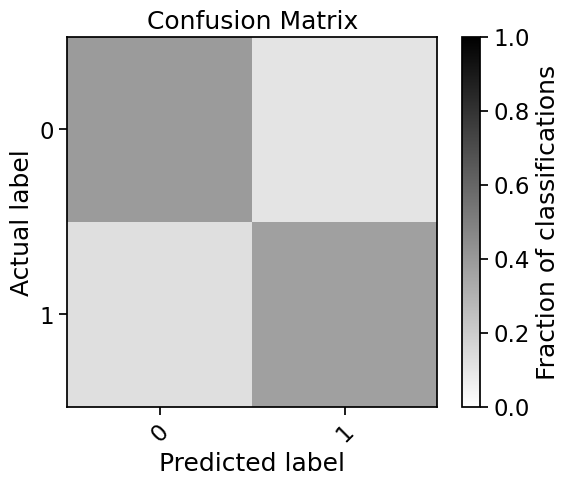

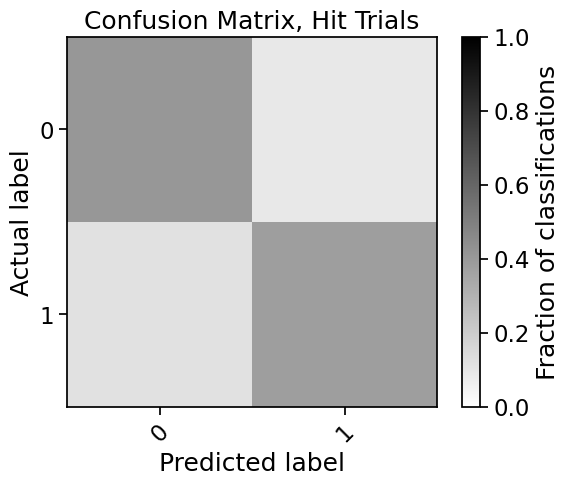

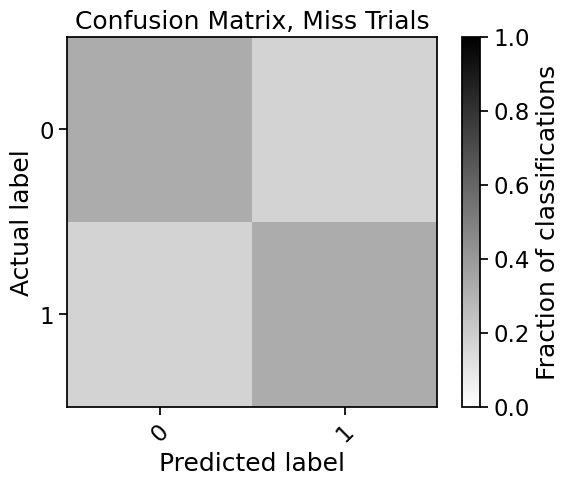

In [71]:
plot_confusion_matrix(confusions, conditions=conditions)
plot_confusion_matrix(confusions_hit, conditions=conditions, title='Confusion Matrix, Hit Trials')
plot_confusion_matrix(confusions_miss, conditions=conditions, title='Confusion Matrix, Miss Trials')

## Exploring the time course of image change-related information 


Next we'll examine the time course of information in our population! Or more specifically: how the length of the spike count window affects the decoding accuracy. Can we decode the stimulus perfectly if we integrate spikes for long enough?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
First, let's try decoding with a longer response window.

In [72]:
responses, labels, hit, miss = make_response_array(spike_times, stimulus_presentations, area_units, window=.2)

Mean accuracy: 0.9301470588235294
Mean accuracy, hit trials: 0.868663594470046
Mean accuracy, miss trials: 0.7636363636363637


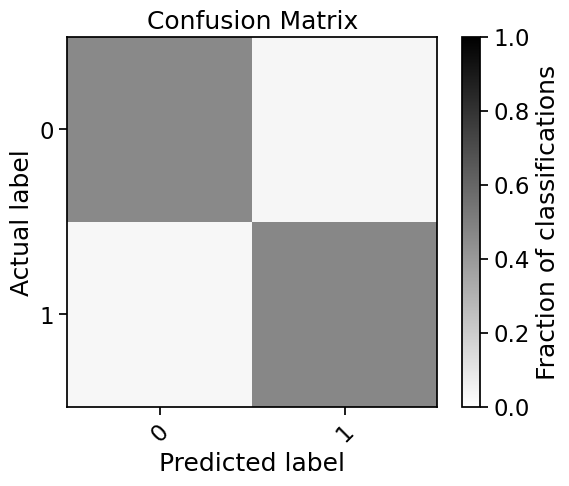

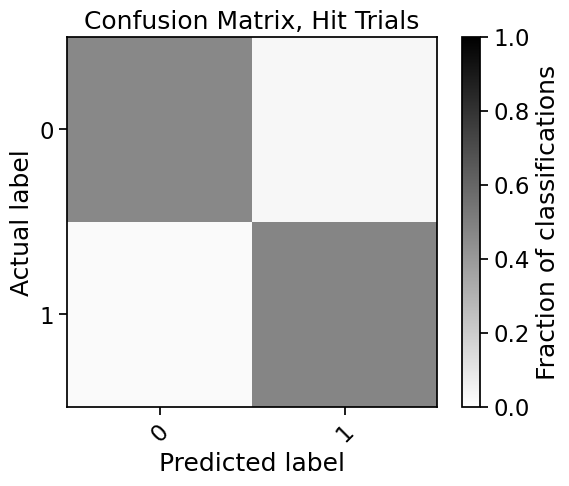

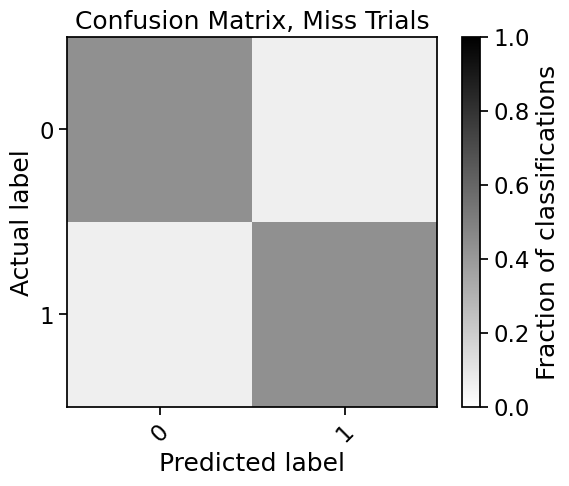

In [73]:
accuracies = []
confusions = []
confusions_hit = []
confusions_miss = []

conditions = np.unique(labels)

for train_indices, test_indices in LeaveOneOut().split(responses):
    
    clf = svm.SVC()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)        
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize=None))
    
    test_hit = hit[test_indices].astype('bool')
    test_miss = miss[test_indices].astype('bool')
    
    if hit[test_indices].astype('bool'):
        accuracies_hit.append(accuracy)
        confusions_hit.append(confusion_matrix(y_true=test_targets[test_hit], y_pred=test_predictions[test_hit], labels=conditions, normalize=None))
        
    elif miss[test_indices].astype('bool'):
        accuracies_miss.append(accuracy)
        confusions_miss.append(confusion_matrix(y_true=test_targets[test_miss], y_pred=test_predictions[test_miss], labels=conditions, normalize=None))

print('Mean accuracy: {}'.format(np.mean(accuracies)))
print('Mean accuracy, hit trials: {}'.format(np.mean(accuracies_hit)) )
print('Mean accuracy, miss trials: {}'.format(np.mean(accuracies_miss)) ) 

plot_confusion_matrix(confusions, conditions=conditions)
plot_confusion_matrix(confusions_hit, conditions=conditions, title='Confusion Matrix, Hit Trials')
plot_confusion_matrix(confusions_miss, conditions=conditions, title='Confusion Matrix, Miss Trials')

With a long response window we can discriminate change vs pre-change almost perfectly based on V1 activity!

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
How long do we need to integrate spikes in order to saturate the decoding performance?

In [74]:
window_lengths = np.arange(.01, .2, .01)

Here we'll use a relaxed, K-Fold cross-validation instead of LeaveOneOut for speed purposes. 

In [75]:
num_splits = 10
accuracies = np.zeros((len(window_lengths), num_splits))
accuracies_hit = np.zeros((len(window_lengths), num_splits))
accuracies_miss = np.zeros((len(window_lengths), num_splits))

for i, window in enumerate(window_lengths):
    print('{}/{}'.format(i, len(window_lengths)))
    responses, labels, hit, miss = make_response_array(spike_times, stimulus_presentations, area_units, window)
    
    k = 0
    for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
        clf = svm.SVC()
        clf.fit(responses[train_indices], labels[train_indices])

        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])

        accuracies[i, k] = np.mean(test_targets == test_predictions)        
        
        test_hit = hit[test_indices].astype('bool')
        test_miss = miss[test_indices].astype('bool')
        
        accuracies_hit[i, k] = np.mean(test_targets[test_hit] == test_predictions[test_hit])
        accuracies_miss[i, k] = np.mean(test_targets[test_miss] == test_predictions[test_miss])
        
        k += 1

0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19


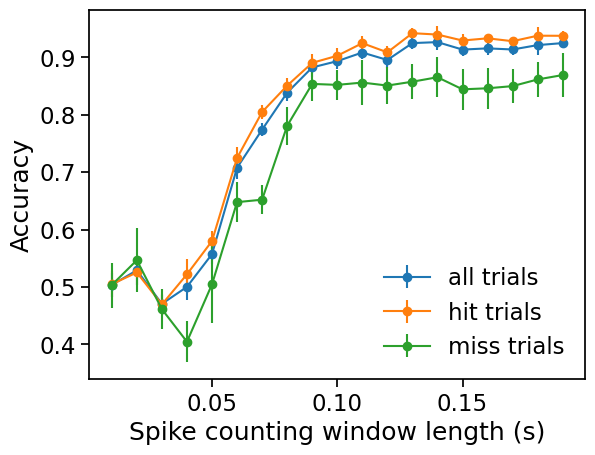

In [76]:
plt.figure()
plt.errorbar(x=window_lengths, y=accuracies.mean(axis=(1)), yerr=accuracies.std(axis=(1))/np.sqrt(num_splits), fmt='o-', label='all trials')
plt.errorbar(x=window_lengths, y=accuracies_hit.mean(axis=(1)), yerr=accuracies_hit.std(axis=(1))/np.sqrt(num_splits), fmt='o-', label='hit trials')
plt.errorbar(x=window_lengths, y=accuracies_miss.mean(axis=(1)), yerr=accuracies_miss.std(axis=(1))/np.sqrt(num_splits), fmt='o-', label='miss trials')

plt.xlabel('Spike counting window length (s)')
plt.ylabel('Accuracy')
plt.legend(loc=0, frameon=False)

## Relationship between population size and decoding accuracy

Next we'll examine how the size of the simultaneously recorded population affects decoding accuracy. In any physiology experiment, we only have a very small window into the overall population response. For example, there are about 500,000 neurons in mouse V1, so in this case we are measuring around 0.02% of the firing rates in this region.

As the number of simultaneously recorded neurons increases, we expect that our ability to decode stimulus identity will improve. 

To start with, let's try decoding with a random sample of 10 neurons

Mean accuracy: 0.6617647058823529
Mean accuracy, hit trials: 0.6682027649769585
Mean accuracy, miss trials: 0.6363636363636364


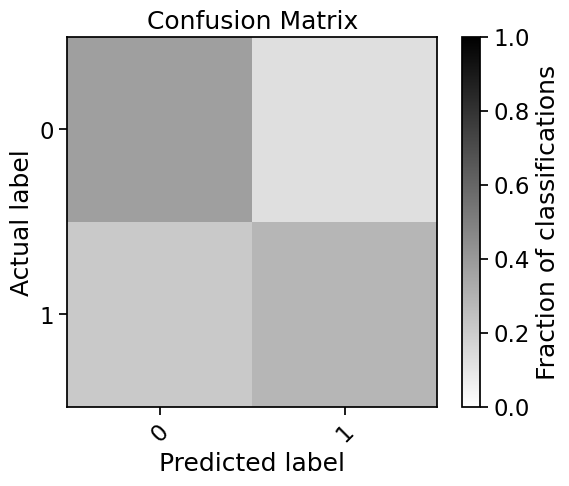

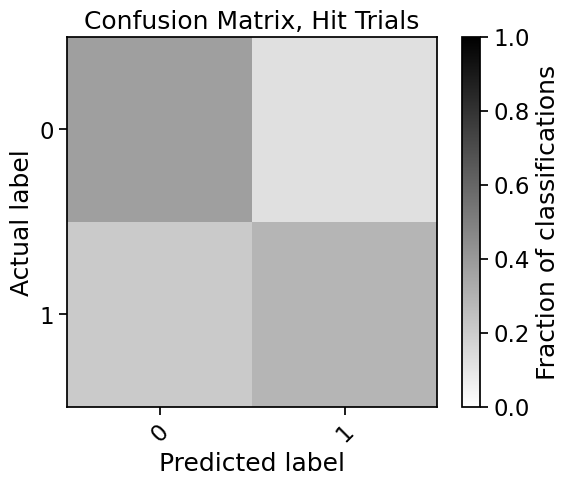

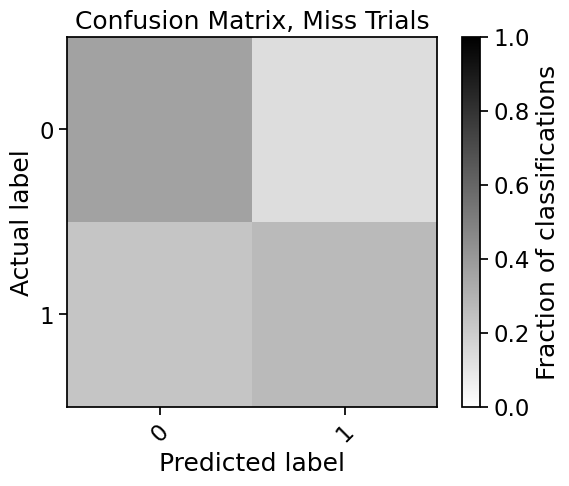

In [77]:
pop_size = 10

pop_idx = np.random.choice(range(num_units), size=pop_size)
responses_pop = responses[:, pop_idx]

accuracies = []
accuracies_hit = []
accuracies_miss = []

confusions = []
confusions_hit = []
confusions_miss = []

conditions = np.unique(labels)

for train_indices, test_indices in LeaveOneOut().split(responses):
    
    clf = svm.SVC()
    clf.fit(responses_pop[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses_pop[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)        
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize=None))
    
    test_hit = hit[test_indices].astype('bool')
    test_miss = miss[test_indices].astype('bool')
    
    if hit[test_indices].astype('bool'):
        accuracies_hit.append(accuracy)
        confusions_hit.append(confusion_matrix(y_true=test_targets[test_hit], y_pred=test_predictions[test_hit], labels=conditions, normalize=None))
        
    elif miss[test_indices].astype('bool'):
        accuracies_miss.append(accuracy)
        confusions_miss.append(confusion_matrix(y_true=test_targets[test_miss], y_pred=test_predictions[test_miss], labels=conditions, normalize=None))

print('Mean accuracy: {}'.format(np.mean(accuracies)))
print('Mean accuracy, hit trials: {}'.format(np.mean(accuracies_hit)) )
print('Mean accuracy, miss trials: {}'.format(np.mean(accuracies_miss)) ) 

        
plot_confusion_matrix(confusions, conditions=conditions)
plot_confusion_matrix(confusions_hit, conditions=conditions, title='Confusion Matrix, Hit Trials')
plot_confusion_matrix(confusions_miss, conditions=conditions, title='Confusion Matrix, Miss Trials')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
Does the result depend on which 10 neurons we sampled? Let's try another random sample.

Mean accuracy: 0.7904411764705882
Mean accuracy, hit trials: 0.804147465437788
Mean accuracy, miss trials: 0.7363636363636363


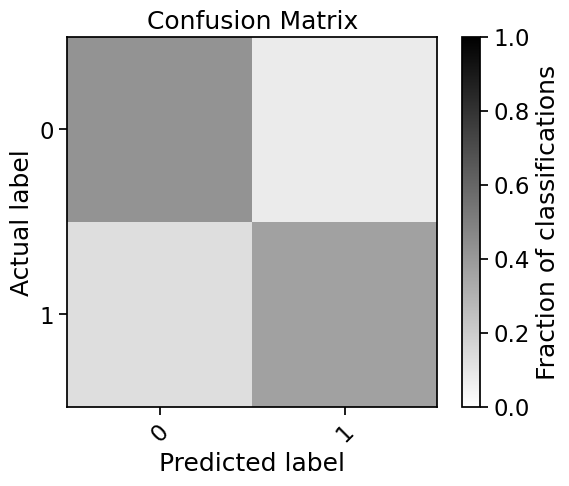

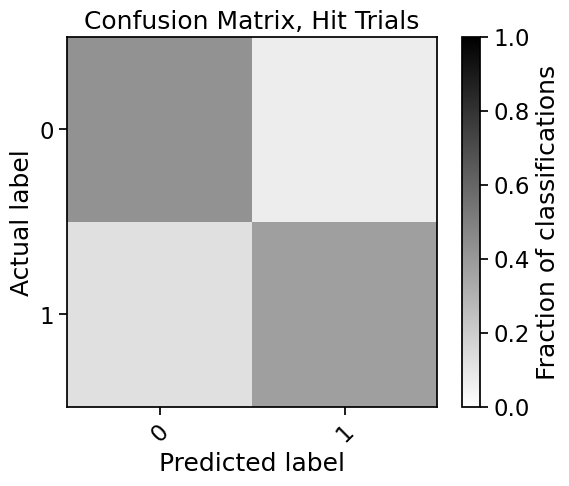

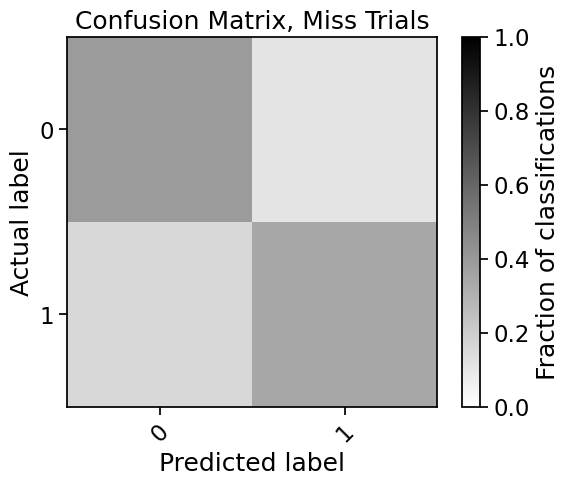

In [78]:
pop_idx = np.random.choice(range(num_units), size=pop_size)
responses_pop = responses[:, pop_idx]

accuracies = []
accuracies_hit = []
accuracies_miss = []

confusions = []
confusions_hit = []
confusions_miss = []

conditions = np.unique(labels)

for train_indices, test_indices in LeaveOneOut().split(responses):
    
    clf = svm.SVC()
    clf.fit(responses_pop[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses_pop[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)        
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize=None))
    
    test_hit = hit[test_indices].astype('bool')
    test_miss = miss[test_indices].astype('bool')
    
    if hit[test_indices].astype('bool'):
        accuracies_hit.append(accuracy)
        confusions_hit.append(confusion_matrix(y_true=test_targets[test_hit], y_pred=test_predictions[test_hit], labels=conditions, normalize=None))
        
    elif miss[test_indices].astype('bool'):
        accuracies_miss.append(accuracy)
        confusions_miss.append(confusion_matrix(y_true=test_targets[test_miss], y_pred=test_predictions[test_miss], labels=conditions, normalize=None))

print('Mean accuracy: {}'.format(np.mean(accuracies)))
print('Mean accuracy, hit trials: {}'.format(np.mean(accuracies_hit)) )
print('Mean accuracy, miss trials: {}'.format(np.mean(accuracies_miss)) ) 

        
plot_confusion_matrix(confusions, conditions=conditions)
plot_confusion_matrix(confusions_hit, conditions=conditions, title='Confusion Matrix, Hit Trials')
plot_confusion_matrix(confusions_miss, conditions=conditions, title='Confusion Matrix, Miss Trials')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
### Now, let's try to get a sense for how this changes with the number of neurons we use to train the classifier. 
    
### How many neurons do you need to decode with roughly 50% accuracy? 80%? 90%? Finish the code below.

In [79]:
pop_sizes = np.arange(1, num_units+5, 5).astype('int')
num_resamples = 10

accuracies = np.zeros((len(pop_sizes), num_resamples, num_splits))
accuracies_hit = np.zeros((len(pop_sizes), num_resamples, num_splits))
accuracies_miss = np.zeros((len(pop_sizes), num_resamples, num_splits))

for i, pop_size in enumerate(pop_sizes):
    print('population size: {}'.format(pop_size))

    for j in range(num_resamples):
        pop_idx = np.random.choice(range(num_units), size=pop_size)
        responses_pop = responses[:, pop_idx]
            
        k = 0
        for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
            clf = svm.SVC()
            clf.fit(responses_pop[train_indices], labels[train_indices])

            test_targets = labels[test_indices]
            test_predictions = clf.predict(responses_pop[test_indices])

            accuracies[i, j, k] = np.mean(test_targets == test_predictions)        

            test_hit = hit[test_indices].astype('bool')
            test_miss = miss[test_indices].astype('bool')

            accuracies_hit[i, j, k] = np.mean(test_targets[test_hit] == test_predictions[test_hit])
            accuracies_miss[i, j, k] = np.mean(test_targets[test_miss] == test_predictions[test_miss])

            k += 1

population size: 1
population size: 6
population size: 11
population size: 16
population size: 21
population size: 26
population size: 31
population size: 36
population size: 41
population size: 46
population size: 51
population size: 56


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


population size: 61
population size: 66
population size: 71


Text(0, 0.5, 'Accuracy')

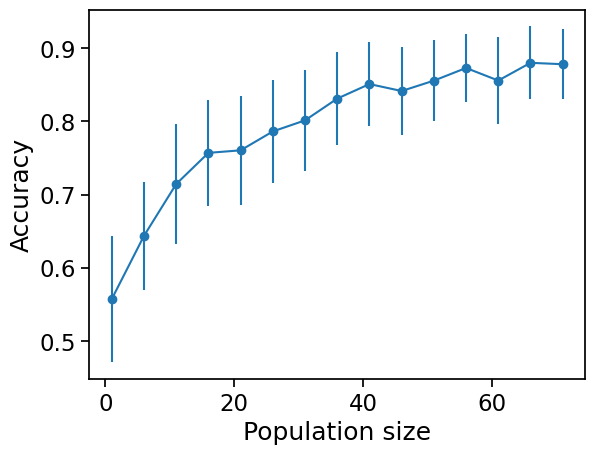

In [80]:
plt.figure()
plt.errorbar(x=pop_sizes, y=accuracies.mean(axis=(1, 2)), yerr=accuracies.std(axis=(1, 2)), fmt='o-')

plt.xlabel('Population size')
plt.ylabel('Accuracy')

Roughly how many neurons do you need to decode with 50% accuracy? 80%? 90%?

# With these analyses in hand, we leave you with some questions:

### If you integrate spikes in a fixed window length, how does the decoding accuracy depend on the time since the image presentation? 

### Where do the lick time distributions fall on the decoding accuracy vs time curve?

### Is the mouse's hit rate different for familiar or novel change images? Is the change decoding accuracy curve different for familiar vs novel change images?


### Are the accuracy curves different in active vs passive blocks?

### Are other variables, including behavioral variables, also encoded in the population activity? Can you decode the running speed, pupil diameter, or licking behavior?

### What about in a different brain area? For example, is the change encoded in CA1 activity? What about in the joint activity across brain areas?